### Predicting purchase intent in e-commerce

In [1]:
### dataset source: https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset

In [2]:
# Installing the watermark package (for recording of previous versions used in this notebook). 
!pip install -q -U watermark

In [3]:
# importing the libraries
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn import svm
import sklearn
import matplotlib
import warnings
warnings.filterwarnings('ignore')

In [4]:
#Loading the dataset
df_original = pd.read_csv('online_shoppers_intention.csv')
df_original.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0.0,0.0,0.0,0.0,1.0,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0.0,0.0,0.0,0.0,2.0,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0.0,-1.0,0.0,-1.0,1.0,-1.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0.0,0.0,0.0,0.0,2.0,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0.0,0.0,0.0,0.0,10.0,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


# Attribute information
The dataset consists of 10 numerical and 8 categorical attributes.
The 'Revenue' attribute can be used as the class label.

"Administrative", "Administrative Duration", "Informational", "Informational Duration", "Product Related" and "Product Related Duration" represent the number of different types of pages visited by the visitor in that session and total time spent in each of these page categories. The values of these features are derived from the URL information of the pages visited by the user and updated in real time when a user takes an action, e.g. moving from one page to another. The "Bounce Rate", "Exit Rate" and "Page Value" features represent the metrics measured by "Google Analytics" for each page in the e-commerce site. The value of "Bounce Rate" feature for a web page refers to the percentage of visitors who enter the site from that page and then leave ("bounce") without triggering any other requests to the analytics server during that session. The value of "Exit Rate" feature for a specific web page is calculated as for all pageviews to the page, the percentage that were the last in the session. The "Page Value" feature represents the average value for a web page that a user visited before completing an e-commerce transaction. The "Special Day" feature indicates the closeness of the site visiting time to a specific special day (e.g. Mother’s Day, Valentine's Day) in which the sessions are more likely to be finalized with transaction. The value of this attribute is determined by considering the dynamics of e-commerce such as the duration between the order date and delivery date. For example, for Valentina’s day, this value takes a nonzero value between February 2 and February 12, zero before and after this date unless it is close to another special day, and its maximum value of 1 on February 8. The dataset also includes operating system, browser, region, traffic type, visitor type as returning or new visitor, a Boolean value indicating whether the date of the visit is weekend, and month of the year.

## EDA

In [5]:
# exploring the shape and type of data
print(df_original.shape)
print(df_original.dtypes)

(12330, 18)
Administrative             float64
Administrative_Duration    float64
Informational              float64
Informational_Duration     float64
ProductRelated             float64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                       object
OperatingSystems             int64
Browser                      int64
Region                       int64
TrafficType                  int64
VisitorType                 object
Weekend                       bool
Revenue                       bool
dtype: object


In [6]:
# checking missing values
print(df_original.isna().sum())

Administrative             14
Administrative_Duration    14
Informational              14
Informational_Duration     14
ProductRelated             14
ProductRelated_Duration    14
BounceRates                14
ExitRates                  14
PageValues                  0
SpecialDay                  0
Month                       0
OperatingSystems            0
Browser                     0
Region                      0
TrafficType                 0
VisitorType                 0
Weekend                     0
Revenue                     0
dtype: int64


In [7]:
# deleting the rows with missing values
df_original.dropna(inplace = True)

In [8]:
# checking results of cleaning
print(df_original.isna().sum())
print(df_original.shape)

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64
(12316, 18)


In [9]:
# checking unique values in each column
df_original.nunique()

Administrative               27
Administrative_Duration    3336
Informational                17
Informational_Duration     1259
ProductRelated              311
ProductRelated_Duration    9552
BounceRates                1872
ExitRates                  4777
PageValues                 2704
SpecialDay                    6
Month                        10
OperatingSystems              8
Browser                      13
Region                        9
TrafficType                  20
VisitorType                   3
Weekend                       2
Revenue                       2
dtype: int64

For organization of dataviz purpose, let's divide the columns considering those with less than 30 unique values are categorical columns, and others are numerical columns.

In [10]:
# creating a copy of original dataset
df = df_original.copy()

# creating the empty lists of column names
continuous = []
categorical = []

# Looping in each column to count the unique values and adding into proper list ceated above
for c in df.columns[:-1]:
    if df.nunique()[c] >= 30:
        continuous.append(c)
    else:
        categorical.append(c)

In [11]:
print(continuous)
df[continuous].head()

['Administrative_Duration', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues']


,Administrative_Duration,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues
0,0.0,0.0,1.0,0.000000,0.20,0.20,0.0
1,0.0,0.0,2.0,64.000000,0.00,0.10,0.0
2,-1.0,-1.0,1.0,-1.000000,0.20,0.20,0.0
3,0.0,0.0,2.0,2.666667,0.05,0.14,0.0
4,0.0,0.0,10.0,627.500000,0.02,0.05,0.0


In [12]:
print(categorical)
df[categorical].head()

['Administrative', 'Informational', 'SpecialDay', 'Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType', 'Weekend']


,Administrative,Informational,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend
0,0.0,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False
1,0.0,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False
2,0.0,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False
3,0.0,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False
4,0.0,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True


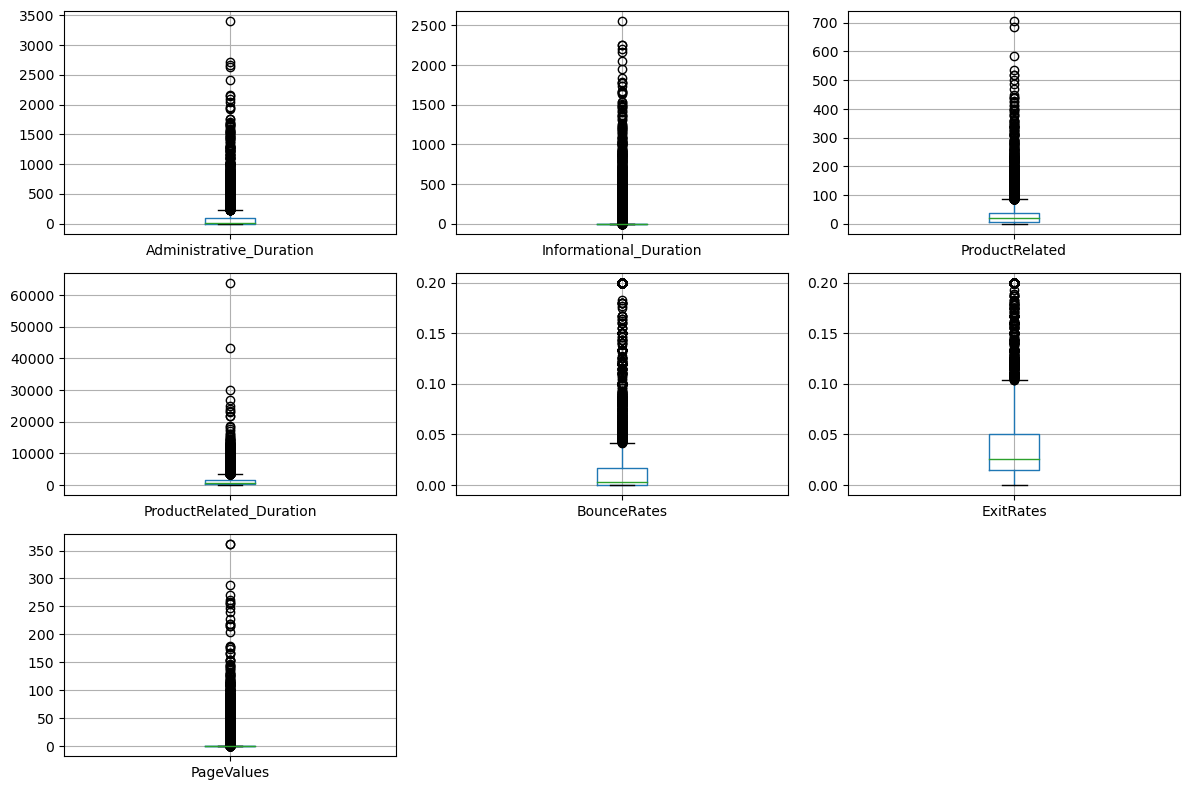

In [13]:
# Ploting the continuous variables
fig = plt.figure(figsize = (12,8))

# Loop for each variable
for i, col in enumerate(continuous):
    plt.subplot(3, 3, i + 1);
    df.boxplot(col);
    plt.tight_layout()
    
plt.savefig('boxplot1.png')

The charts of continuous variables are difficult to read due to data full of small values. Let's apply log transformation.

In [14]:
# applying log transformation for continuous variables
df[continuous] = np.log1p(1 + df[continuous])

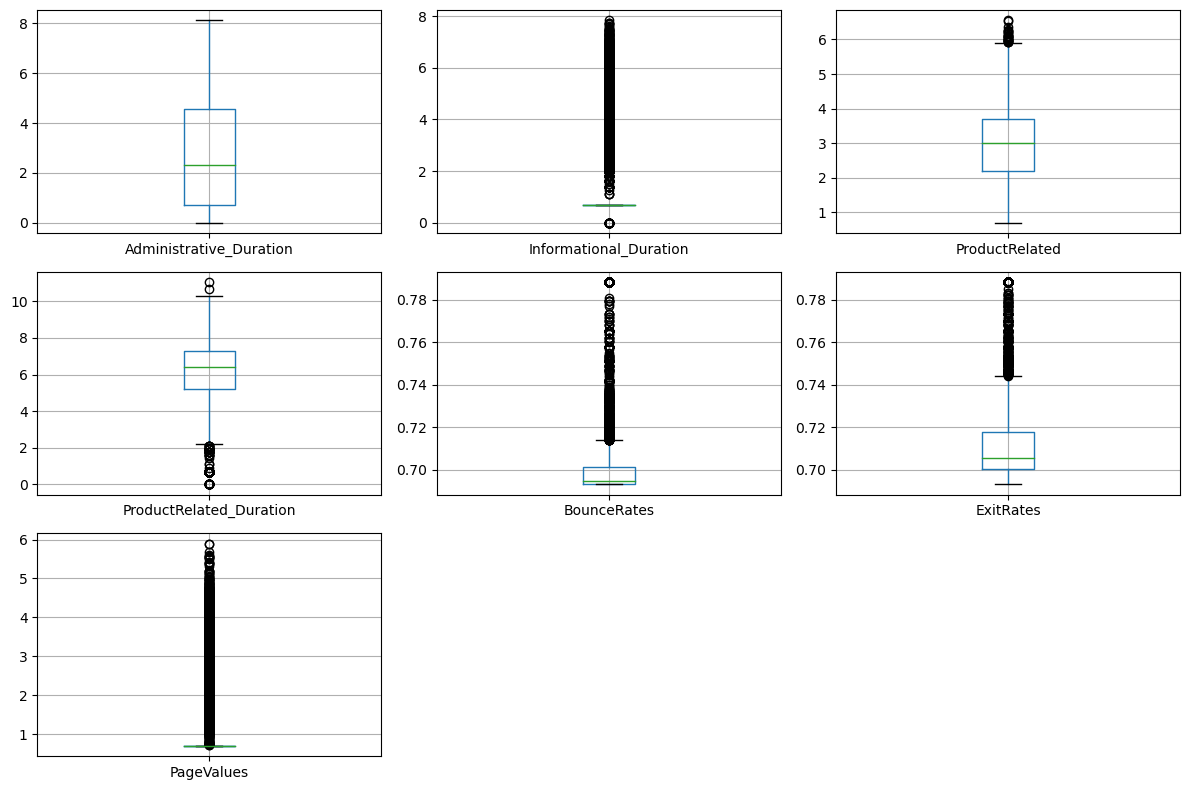

In [15]:
#plotting again
fig = plt.figure(figsize = (12,8))

# Loop pelas variáveis contínuas
for i,col in enumerate(continuous):
    plt.subplot(3,3,i+1);
    df.boxplot(col);
    plt.tight_layout()
plt.savefig('boxplot2.png')

Still difficult to see the plots

<AxesSubplot:>

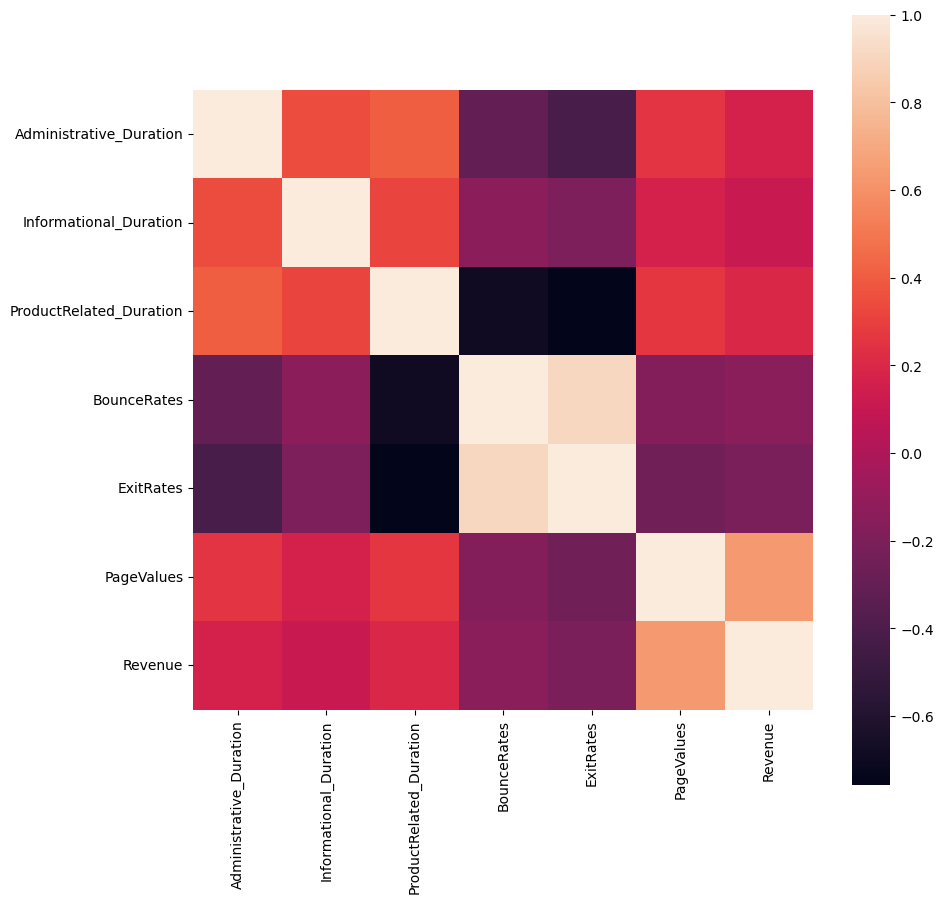

In [16]:
#checking the correlation
plt.figure(figsize = (10,10))

# correlation matrix
sns.heatmap(df[['Administrative_Duration',
                'Informational_Duration',  
                'ProductRelated_Duration',
                'BounceRates', 
                'ExitRates', 
                'PageValues',
                'Revenue']].corr(), vmax = 1., square = True)


BounceRates show negative correlation with Revenue.

Categorical columns: checking the correlation with the target variable (Revenue)

<AxesSubplot:title={'center':'Revenue or Not Revenue'}, xlabel='Revenue', ylabel='count'>

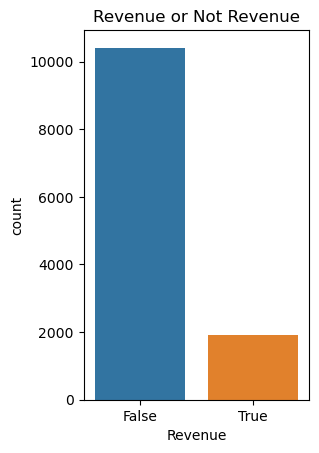

In [17]:
plt.subplot(1,2,2)
plt.title("Revenue or Not Revenue")
sns.countplot(df['Revenue'])

Most of the cases, there is no Revenue.

<AxesSubplot:xlabel='VisitorType', ylabel='count'>

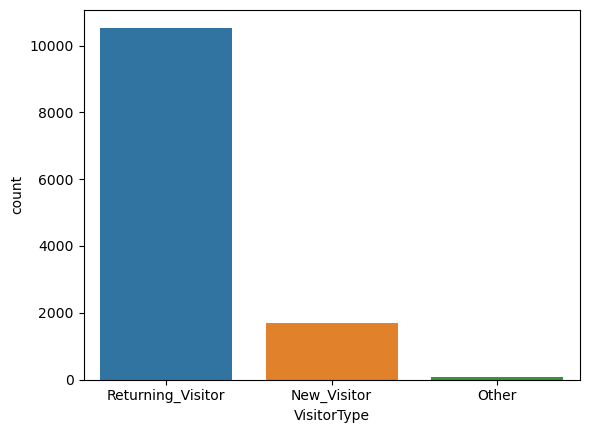

In [18]:
# Countplot visitor type
plt.xlabel("Visitor Type")
sns.countplot(df['VisitorType'])

The chart above shows that most of the Revenue comes from Returning Visitors.

<AxesSubplot:xlabel='VisitorType'>

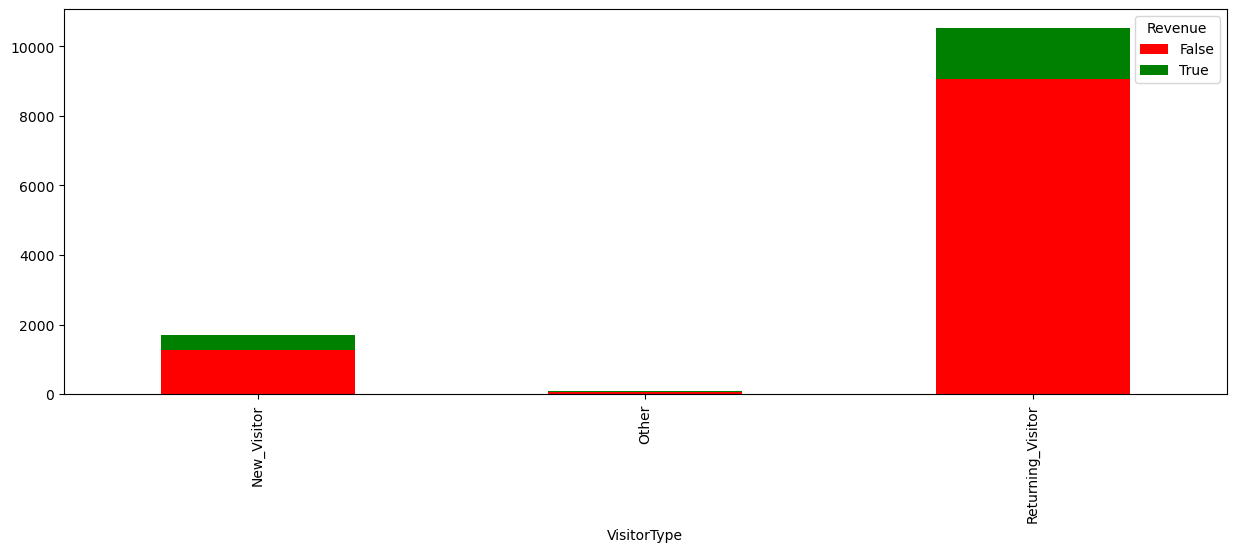

In [19]:
# Stacked Bar Visitor Type x Revenue
pd.crosstab(df['VisitorType'], df['Revenue']).plot(kind = 'bar', 
                                                   stacked = True, 
                                                   figsize = (15, 5), 
                                                   color = ['red', 'green'])

In [20]:
# for Returning Visitors the Revenue seems to be more relevant than in New Visitors.

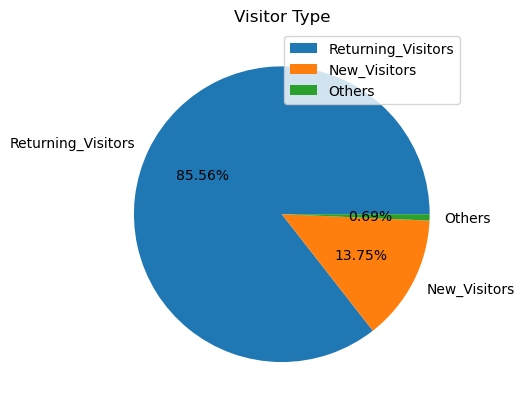

In [21]:
# Pie Chart
labels = ['Returning_Visitors', 'New_Visitors', 'Others']
plt.title("Visitor Type")
plt.pie(df['VisitorType'].value_counts(), labels = labels, autopct = '%.2f%%')
plt.legend()

<AxesSubplot:title={'center':'Weekend or not'}, xlabel='Weekend', ylabel='count'>

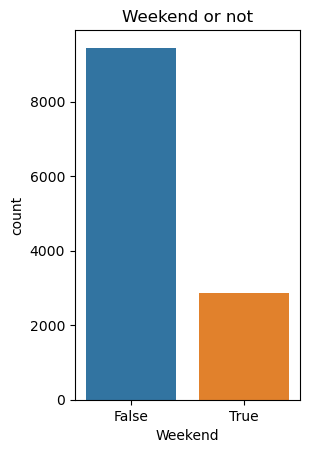

In [22]:
# Countplot Weekend or Weekday
plt.subplot(1,2,1)
plt.title("Weekend or not")
sns.countplot(df['Weekend'])

<AxesSubplot:xlabel='Weekend'>

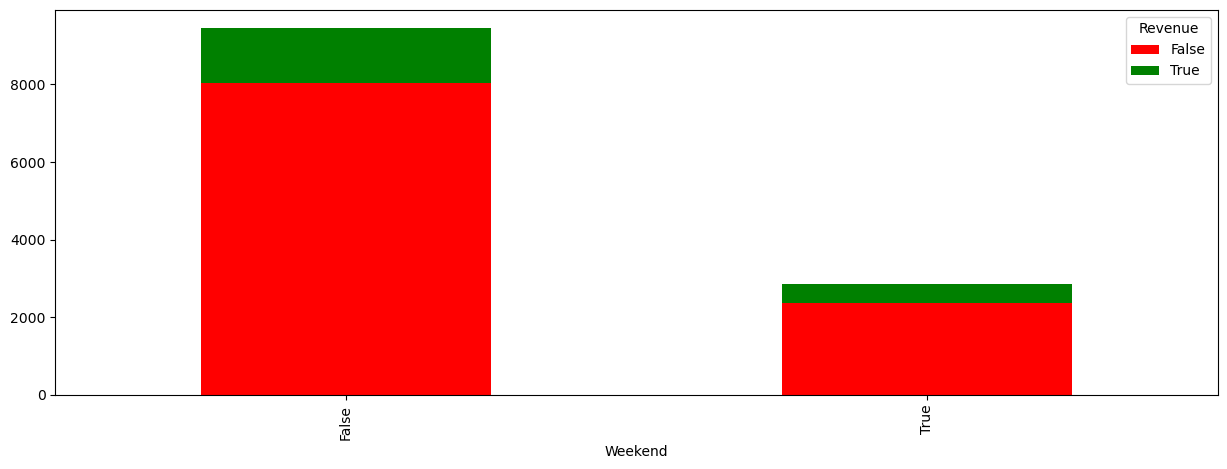

In [23]:
# Stacked Bar Weekend x Revenue
pd.crosstab(df['Weekend'], df['Revenue']).plot(kind = 'bar', 
                                               stacked = True, 
                                               figsize = (15, 5), 
                                               color = ['red', 'green'])

<AxesSubplot:title={'center':'Operacional System Types'}, xlabel='OperatingSystems', ylabel='count'>

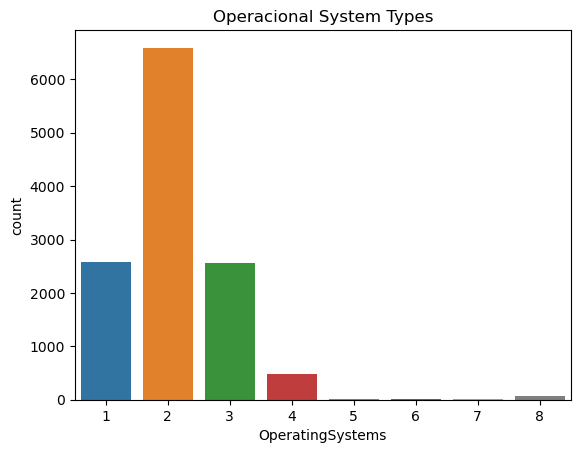

In [24]:
# Countplot Operacional System Type
#plt.figure(figsize = (15,6))
plt.title("Operacional System Types")
plt.xlabel("Operacional System Used")
sns.countplot(df['OperatingSystems'])

<AxesSubplot:xlabel='OperatingSystems'>

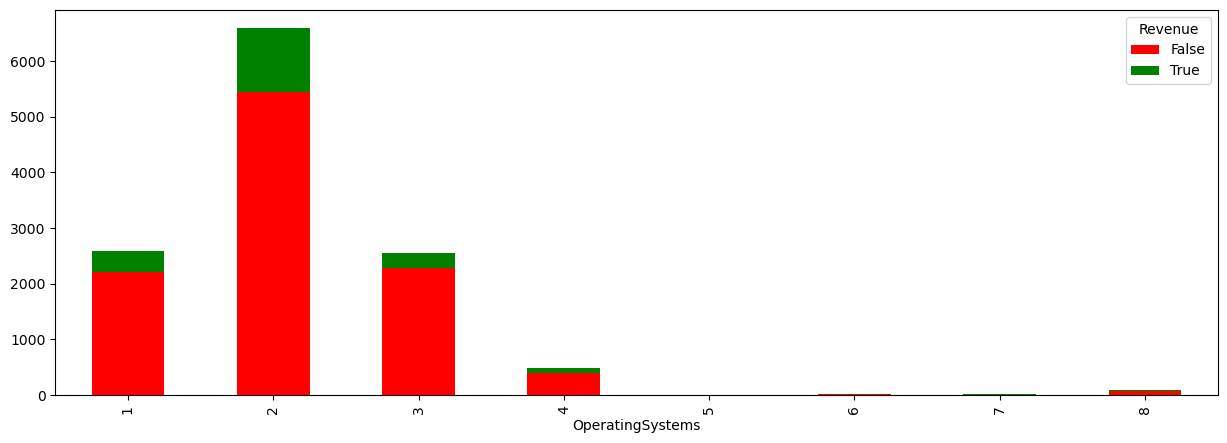

In [25]:
# Stacked Bar Tipo de SO x Revenue
pd.crosstab(df['OperatingSystems'], df['Revenue']).plot(kind = 'bar', 
                                                        stacked = True, 
                                                        figsize = (15, 5), 
                                                        color = ['red', 'green'])

<AxesSubplot:title={'center':'Traffic type'}, xlabel='TrafficType', ylabel='count'>

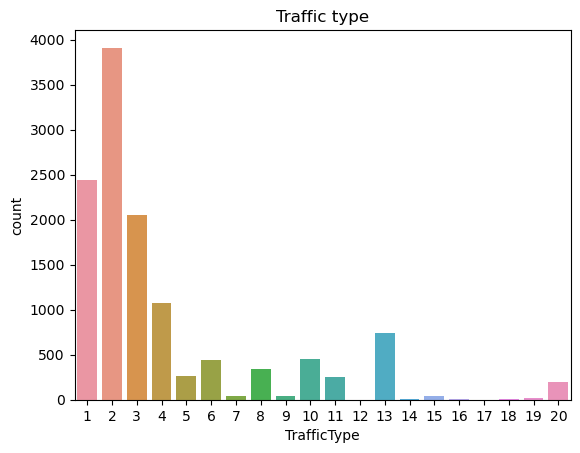

In [26]:
# Countplot Traffic type
plt.title("Traffic type")
plt.xlabel("Traffic type")
sns.countplot(df['TrafficType'])

<AxesSubplot:xlabel='TrafficType'>

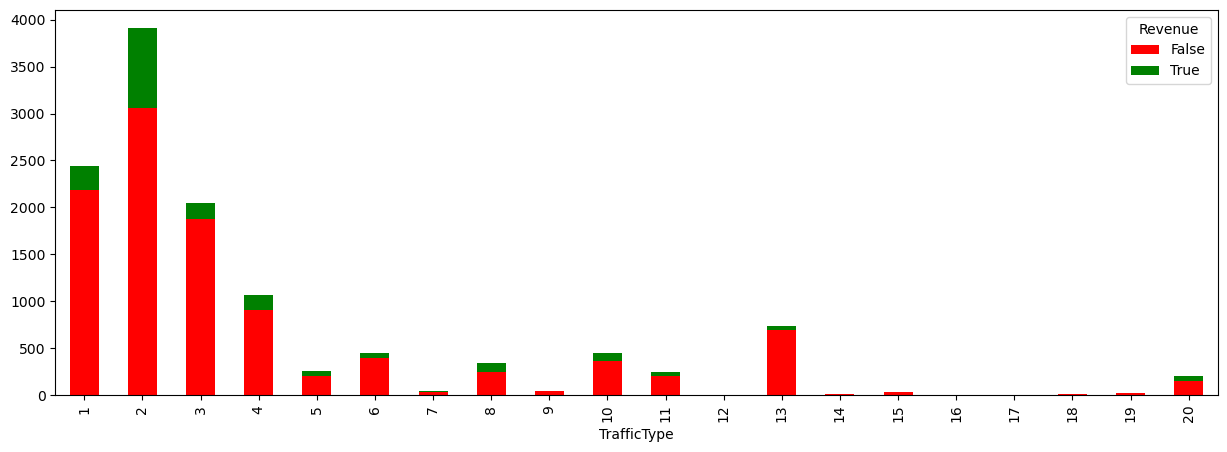

In [27]:
# Stacked Bar Traffic type x Revenue
pd.crosstab(df['TrafficType'], df['Revenue']).plot(kind = 'bar', 
                                                   stacked = True, 
                                                   figsize = (15, 5), 
                                                   color = ['red', 'green'])

## Pre Processing

In [28]:
# creating the encoder
lb = LabelEncoder()

# Apply the encoder with variables with strings (Month and VisitorType) and converting string to number.
# the algotithm requires data with numbers to create the model.
df_original['Month'] = lb.fit_transform(df_original['Month'])
df_original['VisitorType'] = lb.fit_transform(df_original['VisitorType'])

# Removing the missing values
df_original.dropna(inplace = True)

In [29]:
print(df_original.head())
print(df_original.shape)

   Administrative  Administrative_Duration  Informational  \
0             0.0                      0.0            0.0   
1             0.0                      0.0            0.0   
2             0.0                     -1.0            0.0   
3             0.0                      0.0            0.0   
4             0.0                      0.0            0.0   

   Informational_Duration  ProductRelated  ProductRelated_Duration  \
0                     0.0             1.0                 0.000000   
1                     0.0             2.0                64.000000   
2                    -1.0             1.0                -1.000000   
3                     0.0             2.0                 2.666667   
4                     0.0            10.0               627.500000   

   BounceRates  ExitRates  PageValues  SpecialDay  Month  OperatingSystems  \
0         0.20       0.20         0.0         0.0      2                 1   
1         0.00       0.10         0.0         0.0      2

In [30]:
# checking if the numbers of rows for Revenue column has the same amount of True or False
# to avoid bias
target_count = df_original.Revenue.value_counts()
target_count

False    10408
True      1908
Name: Revenue, dtype: int64

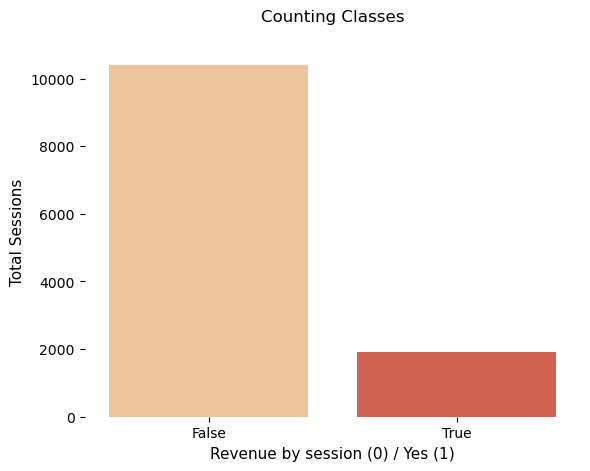

In [31]:
# Plot 
sns.countplot(df_original.Revenue, palette = "OrRd")
plt.box(False)
plt.xlabel('Revenue by session (0) / Yes (1)', fontsize = 11)
plt.ylabel('Total Sessions', fontsize = 11)
plt.title('Counting Classes\n')
plt.show()

In the chart above we can see much more samples for Not Revenue(False) than for Revenue (True)
There are basically two ways to balance the sample. Creating more Trues or deleting Falses.
In this case is better create more Trues because there are few rows of data to train the model, which can impact the learning performance and accuracy of the algorithm.

In [32]:
# let's use the imblearn to increase the True samples. 
!pip install -q imblearn
import imblearn

In [33]:
df_original.shape

(12316, 18)

In [34]:
# Explanatory variables
df_original.iloc[:, 0:17].head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend
0,0.0,0.0,0.0,0.0,1.0,0.000000,0.20,0.20,0.0,0.0,2,1,1,1,1,2,False
1,0.0,0.0,0.0,0.0,2.0,64.000000,0.00,0.10,0.0,0.0,2,2,2,1,2,2,False
2,0.0,-1.0,0.0,-1.0,1.0,-1.000000,0.20,0.20,0.0,0.0,2,4,1,9,3,2,False
3,0.0,0.0,0.0,0.0,2.0,2.666667,0.05,0.14,0.0,0.0,2,3,2,2,4,2,False
4,0.0,0.0,0.0,0.0,10.0,627.500000,0.02,0.05,0.0,0.0,2,3,3,1,4,2,True


In [35]:
# Target variables
df_original.iloc[:, 17].head()

0    False
1    False
2    False
3    False
4    False
Name: Revenue, dtype: bool

### Oversampling

In [36]:
# Importing the function to balance the sample of data with same amount for revenue and no revenue
from imblearn.over_sampling import SMOTE

# set seed for reference of the simulation
seed = 100

# Splitting X and y
X = df_original.iloc[:, 0:17]  
y = df_original.iloc[:, 17] 

# Creating the SMOTE balance
smote_bal = SMOTE(random_state = seed)

# Applying the function
X_res, y_res = smote_bal.fit_resample(X, y)

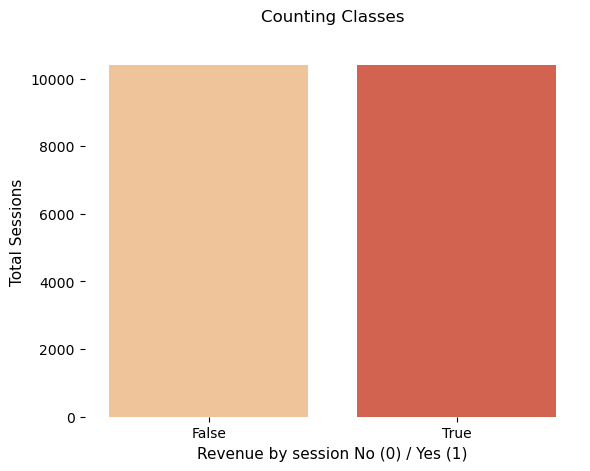

In [37]:
# Plot 
sns.countplot(y_res, palette = "OrRd")
plt.box(False)
plt.xlabel('Revenue by session No (0) / Yes (1)', fontsize = 11)
plt.ylabel('Total Sessions', fontsize = 11)
plt.title('Counting Classes\n')
plt.show()

In [38]:
#comparing the shape from original to new dataset
print(df_original.shape)
print(X_res.shape)

(12316, 18)
(20816, 17)


In [39]:
#shape of resample data
y_res.shape

(20816,)

In [40]:
#defining X and y
X = X_res
y = y_res

In [42]:
# splitting the data for train and test
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size = 0.3, random_state = 42)

# SVM Model

### Base model with Linear Kernel

In [43]:
# Creating the model
modelo_v1 = svm.SVC(kernel = 'linear')

In [45]:
# Training (This cell will take around 1 hour 5 min  to calculate)
start = time.time()
modelo_v1.fit(X_treino, y_treino)
end = time.time()
print('Training time: ', (end-start)/60, 'minutes')

Training time:  61.557443197568254 minutes


In [46]:
# Predicting
previsoes_v1 = modelo_v1.predict(X_teste)

In [58]:
SVM_dict_v1 = {'Modelo':'SVM',
               'Version':'1',
               'Kernel':'Linear',
               'Precision':precision_score(previsoes_v1,y_teste),
               'Recall': recall_score(previsoes_v1,y_teste),
               'F1 Score':f1_score(previsoes_v1,y_teste),
               'AUC':roc_auc_score(y_teste, previsoes_v1)}

In [59]:
#printing
print("Metrics in Test:\n")
SVM_dict_v1

Metrics in Test:



{'Modelo': 'SVM',
 'Version': '1',
 'Kernel': 'Linear',
 'Precision': 0.8672370088719898,
 'Recall': 0.795177222545032,
 'F1 Score': 0.8296453470748711,
 'AUC': 0.8195039042417572}

 ### Linear Kernel and Standardized Data (with same scale)

In [60]:
# Standardizing
X_treino_scaled = StandardScaler().fit_transform(X_treino)
X_teste_scaled = StandardScaler().fit_transform(X_teste)

In [61]:
# Creating the model
modelo_v2 = svm.SVC(kernel = 'linear')

In [62]:
# Training
start = time.time()
modelo_v2.fit(X_treino_scaled, y_treino)
end = time.time()
print('Training time: ', (end-start)/60, 'minutes')

Training time:  0.10554887056350708 minutes


In [63]:
# Predicting
previsoes_v2 = modelo_v2.predict(X_teste_scaled)

In [64]:
SVM_dict_v2 = {'Modelo':'SVM',
               'Version':'2',
               'Kernel':'Linear with standardized data',
               'Precision':precision_score(previsoes_v2,y_teste),
               'Recall': recall_score(previsoes_v2,y_teste),
               'F1 Score':f1_score(previsoes_v2,y_teste),
               'AUC':roc_auc_score(y_teste, previsoes_v2)}

In [57]:
#printing
print("Metrics in Test:\n")
SVM_dict_v2

Metrics in Test:



{'Modelo': 'SVM',
 'Version': '2',
 'Kernel': 'Linear with standardized data',
 'Precision': 0.7867553865652726,
 'Recall': 0.8912419239052405,
 'F1 Score': 0.8357455402221474,
 'AUC': 0.8443326949012832}

### Hyperparameters optimization with Grid Search and Kernel RBF

In [66]:
# Creating the model
modelo_v3 = svm.SVC(kernel = 'rbf')

# Values for grid
C_range = np.array([50., 100., 200.])
gamma_range = np.array([0.3*0.001,0.001,3*0.001])

# Hyperparameters grid
svm_param_grid = dict(gamma = gamma_range, C = C_range)

# Grid Search
start = time.time()
modelo_v3_grid_search_rbf = GridSearchCV(modelo_v3, svm_param_grid, cv = 3)

# Training
modelo_v3_grid_search_rbf.fit(X_treino_scaled, y_treino)
end = time.time()
print('Training time of Grid Search model:', end - start)

# Acurácia em Treino
print(f"Training accuracy: {modelo_v3_grid_search_rbf.best_score_ :.2%}")
print("")
print(f"Ideal hyperparameters: {modelo_v3_grid_search_rbf.best_params_}")

Training time of Grid Search model: 107.7128791809082
Training accuracy: 87.41%

Ideal hyperparameters: {'C': 200.0, 'gamma': 0.003}


In [67]:
# Predicting
previsoes_v3 = modelo_v3_grid_search_rbf.predict(X_teste_scaled)

In [68]:
# Dictionary for metrics and metadata
SVM_dict_v3 = {'Modelo':'SVM',
               'Versão':'3',
               'Kernel':'RBF with standardized data',
               'Precision':precision_score(previsoes_v3, y_teste),
               'Recall':recall_score(previsoes_v3, y_teste),
               'F1 Score':f1_score(previsoes_v3, y_teste),
               'Accuracy':accuracy_score(previsoes_v3, y_teste),
               'AUC':roc_auc_score(y_teste, previsoes_v3)}

In [69]:
# Print
print("Test metrics:\n")
SVM_dict_v3

Test metrics:



{'Modelo': 'SVM',
 'Versão': '3',
 'Kernel': 'RBF with standardized data',
 'Precision': 0.8368187579214195,
 'Recall': 0.8986049676760803,
 'F1 Score': 0.8666119770303528,
 'Accuracy': 0.8698158526821457,
 'AUC': 0.8701737039849895}

### Otimização de Hiperparâmetros com Grid Search e Kernel Polinomial

In [70]:
# Creating the model
modelo_v4 = svm.SVC(kernel = 'poly')

# Values for grid
r_range =  np.array([0.5, 1])
gamma_range =  np.array([0.001, 0.01])
d_range = np.array([2,3, 4])

# Hyiperparameters for grid
param_grid_poly = dict(gamma = gamma_range, degree = d_range, coef0 = r_range)

# Grid Search
start = time.time()
modelo_v4_grid_search_poly = GridSearchCV(modelo_v4, param_grid_poly, cv = 3)

# Training
modelo_v4_grid_search_poly.fit(X_treino_scaled, y_treino)
end = time.time()
print('Training time of Grid Search model:', end - start)

# Acurácia em Treino
print(f"Training accuracy: {modelo_v4_grid_search_poly.best_score_ :.2%}")
print("")
print(f"Ideal hyperparameters: {modelo_v4_grid_search_poly.best_params_}")

Training time of Grid Search model: 96.8588969707489
Training accuracy: 86.14%

Ideal hyperparameters: {'coef0': 1.0, 'degree': 4, 'gamma': 0.01}


In [71]:
# Previsões
previsoes_v4 = modelo_v4_grid_search_poly.predict(X_teste_scaled)

In [72]:
# Dicionário de métricas e metadados
SVM_dict_v4 = {'Modelo':'SVM',
               'Versão':'4',
               'Kernel':'Polinomial with standardized data',
               'Precision':precision_score(previsoes_v4, y_teste),
               'Recall':recall_score(previsoes_v4, y_teste),
               'F1 Score':f1_score(previsoes_v4, y_teste),
               'Accuracy':accuracy_score(previsoes_v4, y_teste),
               'AUC':roc_auc_score(y_teste, previsoes_v4)}

In [73]:
# Print
print("Test metrics:\n")
SVM_dict_v4

Test metrics:



{'Modelo': 'SVM',
 'Versão': '4',
 'Kernel': 'Polinomial with standardized data',
 'Precision': 0.80893536121673,
 'Recall': 0.8932820153953814,
 'F1 Score': 0.8490189557698703,
 'Accuracy': 0.8546036829463571,
 'AUC': 0.8550989528647587}

In [74]:
# Concatenating the dictionaries in Pandas dataframe
summary = pd.DataFrame({'SVM_dict_v1':pd.Series(SVM_dict_v1),
                       'SVM_dict_v2':pd.Series(SVM_dict_v2),
                       'SVM_dict_v3':pd.Series(SVM_dict_v3),
                       'SVM_dict_v4':pd.Series(SVM_dict_v4)})

In [75]:
# Print
summary

,SVM_dict_v1,SVM_dict_v2,SVM_dict_v3,SVM_dict_v4
AUC,0.819504,0.844333,0.870174,0.855099
Accuracy,NaN,NaN,0.869816,0.854604
F1 Score,0.829645,0.835746,0.866612,0.849019
Kernel,Linear,Linear with standardized data,RBF with standardized data,Polinomial with standardized data
Modelo,SVM,SVM,SVM,SVM
Precision,0.867237,0.786755,0.836819,0.808935
Recall,0.795177,0.891242,0.898605,0.893282
Version,1,2,NaN,NaN
Versão,NaN,NaN,3,4


### Making the predictions with the trained model

In [76]:
# New register
novo_x = np.array([4.0, 5.56, 1.0, 3.78, 2.995, 6.00, 0.69, 0.70, 0.69, 0, 6, 1, 1, 3, 3, 2, False]).reshape(1, -1)

In [77]:
# Standardizing the register
novo_x_scaled = StandardScaler().fit_transform(novo_x)

In [78]:
# Predicting
previsao_novo_x = modelo_v3_grid_search_rbf.predict(novo_x_scaled)

In [79]:
previsao_novo_x

array([ True])

The customer will buy.